In [23]:
## 📌 Importar Librerías
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objects as go
import yfinance as yf


In [24]:
## 📌 API Key de Alpha Vantage y función para descargar datos
ALPHA_VANTAGE_API_KEY = "6XE23J2QP58EE8L7"

def obtener_datos_alpha_vantage(ticker, api_key, intentos=5):
    ts = TimeSeries(key=api_key, output_format='pandas')
    for i in range(intentos):
        try:
            print(f"Descargando datos para {ticker} (Intento {i+1}/{intentos})...")
            data, _ = ts.get_daily(symbol=ticker, outputsize='full')
            data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            data.index = pd.to_datetime(data.index)
            return data.sort_index()
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(5)
    raise Exception("No se pudieron descargar los datos.")


In [25]:
## 📌 Configuración del Ticker y rango de fechas, y descarga de datos
ticker = 'RDDT'
start_date = datetime.datetime(2022, 1, 1)

data = obtener_datos_alpha_vantage(ticker, ALPHA_VANTAGE_API_KEY)
data = data.loc[data.index >= start_date]
print(f"Última fecha disponible en los datos: {data.index.max()}")


Descargando datos para RDDT (Intento 1/5)...
Última fecha disponible en los datos: 2025-03-06 00:00:00


In [26]:
# %%
## 📌 Calcular Indicadores Técnicos

# --- Cálculo CORRECTO del RSI con Media Móvil Exponencial ---
window_rsi = 14
delta = data['Close'].diff(1)
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=data.index).ewm(span=window_rsi, adjust=False).mean()
avg_loss = pd.Series(loss, index=data.index).ewm(span=window_rsi, adjust=False).mean()
rs = avg_gain / (avg_loss + 1e-10)  # Evitar división por cero
data['RSI'] = 100 - (100 / (1 + rs))

# --- Cálculo del MACD, Línea de Señal y Histograma ---
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']

# --- Cálculo del Estocástico ---
data['%K'] = 100 * (data['Close'] - data['Low'].rolling(14).min()) / (data['High'].rolling(14).max() - data['Low'].rolling(14).min())
data['%D'] = data['%K'].rolling(3).mean()

# --- Índice de Capital Institucional (ICI) basado en Volumen ---
data['Volume_MA_50'] = data['Volume'].rolling(window=50).mean()
data['Institutional_Index'] = data['Volume'] / data['Volume_MA_50']

# --- Cálculo del OBV (On Balance Volume) ---
data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

# --- Definir Entrada y Salida de Capital basados en umbrales ---
entrada_umbral = 2.0
salida_umbral = 0.5
data['Entrada_Capital'] = (data['Institutional_Index'] > entrada_umbral).astype(int)
data['Salida_Capital'] = (data['Institutional_Index'] < salida_umbral).astype(int)


In [27]:
## 📌 Preprocesamiento de Datos

data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# --- Seleccionar características para el modelo ---
features = ['RSI', 'MACD', 'Signal_Line', '%K', '%D', 'Volume', 'Institutional_Index', 'OBV']
X = data[features].values
y = data['Entrada_Capital'].values  

# --- Normalización de Datos ---
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Definir input_dim (número de features) para el modelo LSTM
input_dim = X_scaled.shape[1]


In [28]:
# %%
## 📌 Optimización y Validación Cruzada con TimeSeriesSplit para LSTM y XGBoost

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')  # Suprimir advertencias

# --- 🔹 Función para construir el modelo LSTM ---
def build_lstm_model(neurons1, neurons2, dropout, learning_rate):
    model = Sequential([
        LSTM(neurons1, return_sequences=True, input_shape=(1, X_scaled.shape[1])),
        Dropout(dropout),
        LSTM(neurons2),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# --- Función para optimizar manualmente el modelo LSTM ---
def optimize_lstm(X_train, y_train, X_test, y_test, param_grid):
    best_acc = 0
    best_model = None
    best_params = {}
    
    # Remodelar los datos para LSTM
    X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    # Callback de EarlyStopping para detener el entrenamiento si no hay mejora en la validación
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    for neurons1 in param_grid['neurons1']:
        for neurons2 in param_grid['neurons2']:
            for dropout in param_grid['dropout']:
                for learning_rate in param_grid['learning_rate']:
                    for batch_size in param_grid['batch_size']:
                        for epochs in param_grid['epochs']:
                            model = build_lstm_model(neurons1, neurons2, dropout, learning_rate)
                            model.fit(X_train_reshaped, y_train, 
                                      epochs=epochs, 
                                      batch_size=batch_size, 
                                      validation_data=(X_test_reshaped, y_test),
                                      callbacks=[early_stop],
                                      verbose=0)
                            acc = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
                            
                            if acc > best_acc:
                                best_acc = acc
                                best_model = model
                                best_params = {
                                    'neurons1': neurons1,
                                    'neurons2': neurons2,
                                    'dropout': dropout,
                                    'learning_rate': learning_rate,
                                    'batch_size': batch_size,
                                    'epochs': epochs
                                }
    return best_model, best_params, X_train_reshaped, X_test_reshaped

# --- Inicialización de variables ---
fold = 1
metrics_list = []
best_params_folds = []
y_test_final = None
y_pred_final = None

# --- Validación Cruzada usando TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_scaled):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # --- Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento ---
    minority_class_samples = np.sum(y_train == 1)
    if minority_class_samples >= 2:
        print(f"Aplicando SMOTE en Fold {fold} con {minority_class_samples} ejemplos de la clase minoritaria...")
        smote = SMOTE(random_state=42, k_neighbors=min(3, minority_class_samples-1))
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # --- Optimización Manual de Hiperparámetros para LSTM ---
    param_grid_lstm = {
        'neurons1': [64, 128],
        'neurons2': [25, 50],
        'dropout': [0.2, 0.3],
        'learning_rate': [0.001, 0.0005],
        'batch_size': [16, 32],
        'epochs': [30, 50]
    }
    best_lstm_model, best_params, X_train_reshaped, X_test_reshaped = optimize_lstm(X_train, y_train, X_test, y_test, param_grid_lstm)
    print(f"Fold {fold} - Mejores parámetros LSTM: {best_params}")
    
    # --- Generar características con el mejor modelo LSTM ---
    X_train_lstm_features = best_lstm_model.predict(X_train_reshaped).flatten()
    X_test_lstm_features = best_lstm_model.predict(X_test_reshaped).flatten()
    
    # --- Optimización de Hiperparámetros para XGBoost ---
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [6, 8],
        'scale_pos_weight': [10, 15]
    }
    grid_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                                  param_distributions=param_grid_xgb, 
                                  cv=TimeSeriesSplit(n_splits=3), 
                                  scoring='accuracy', 
                                  n_iter=5, 
                                  random_state=42)
    grid_xgb.fit(X_train_lstm_features.reshape(-1, 1), y_train)
    print(f"Fold {fold} - Mejores parámetros XGBoost: {grid_xgb.best_params_}")
    
    # --- Guardar los mejores parámetros del fold ---
    best_params_folds.append({
        'fold': fold,
        'lstm_params': best_params,
        'xgb_params': grid_xgb.best_params_
    })
    
    # --- Entrenar modelo XGBoost con los mejores parámetros y predecir ---
    best_xgb_model = grid_xgb.best_estimator_
    y_pred = best_xgb_model.predict(X_test_lstm_features.reshape(-1, 1))
    
    # --- Evaluación del fold ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Fold {fold} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")
    
    metrics_list.append({
        'fold': fold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc_roc': auc
    })
    
    # Guardar resultados del último fold para visualización
    y_test_final = y_test
    y_pred_final = y_pred
    
    fold += 1

# --- Mostrar métricas promedio ---
avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']}
print("\n--- Métricas Promedio en Cross-Validation ---")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# --- Mostrar los mejores parámetros obtenidos en cada fold ---
print("\n--- Mejores Parámetros por Fold ---")
for params in best_params_folds:
    print(params)



--- Fold 1 ---
Fold 1 - Mejores parámetros LSTM: {'neurons1': 64, 'neurons2': 25, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Fold 1 - Mejores parámetros XGBoost: {'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Fold 1 - Accuracy: 0.9032, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, AUC-ROC: 0.5000

--- Fold 2 ---
Aplicando SMOTE en Fold 2 con 3 ejemplos de la clase minoritaria...
Fold 2 - Mejores parámetros LSTM: {'neurons1': 64, 'neurons2': 25, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 16, 'epochs': 30}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Fold 2 - Mejores parámetros XGBoost: {'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Fold 2 - Accuracy: 0.9677, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, AUC-ROC: 0.5000

--- Fold 3 ---
Aplicando SMOTE e

KeyboardInterrupt: 

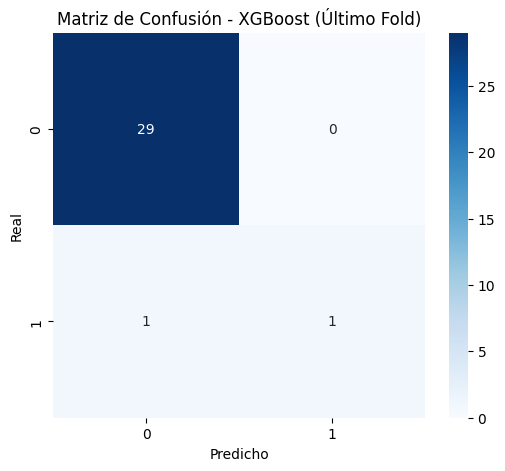

In [ ]:
## 📌 Visualización: Matriz de Confusión para el último fold
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost (Último Fold)')
plt.show()


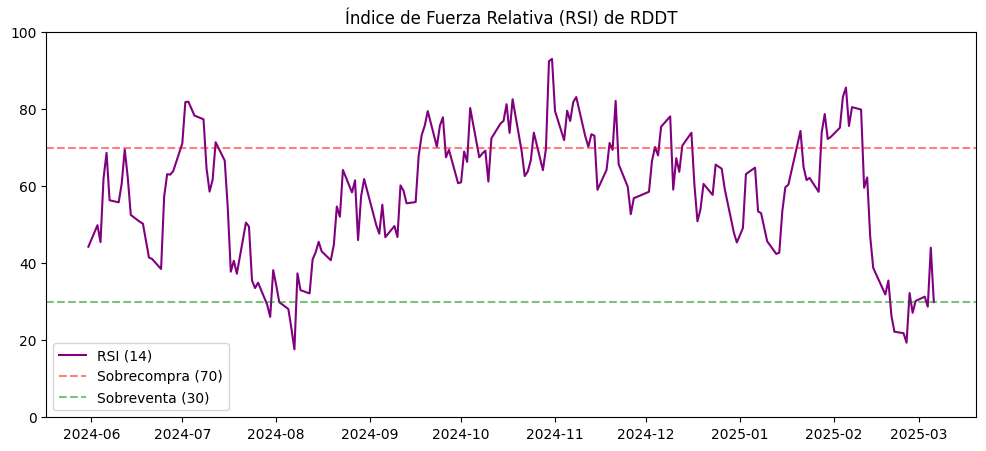

In [ ]:
# %%
## 📌 Visualización: Gráfico del RSI
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['RSI'], color='purple', label="RSI (14)")
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label="Sobrecompra (70)")
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label="Sobreventa (30)")
plt.ylim(0, 100)
plt.title(f'Índice de Fuerza Relativa (RSI) de {ticker}')
plt.legend()
plt.show()


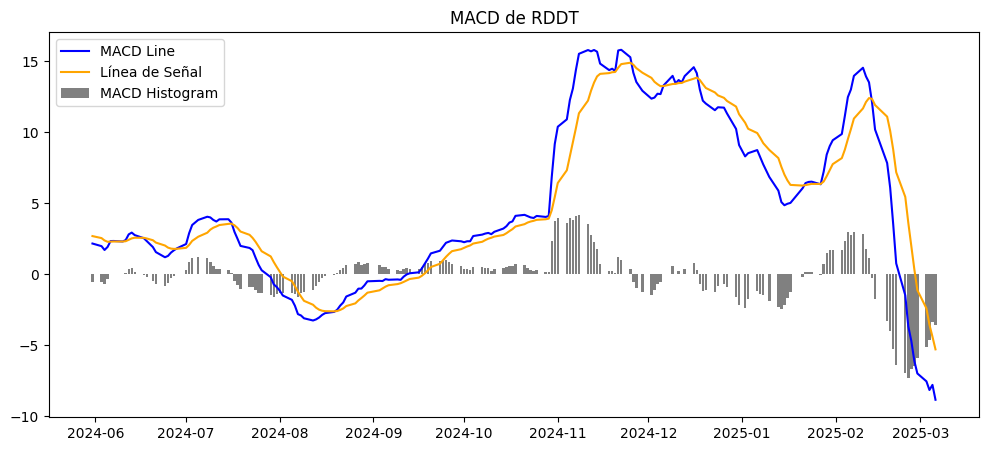

In [ ]:
## 📌 Visualización: Gráfico MACD
plt.figure(figsize=(12, 5))
plt.bar(data.index, data['MACD_Histogram'], color='gray', label="MACD Histogram")
plt.plot(data.index, data['MACD'], color='blue', label="MACD Line")
plt.plot(data.index, data['Signal_Line'], color='orange', label="Línea de Señal")
plt.title(f'MACD de {ticker}')
plt.legend()
plt.show()


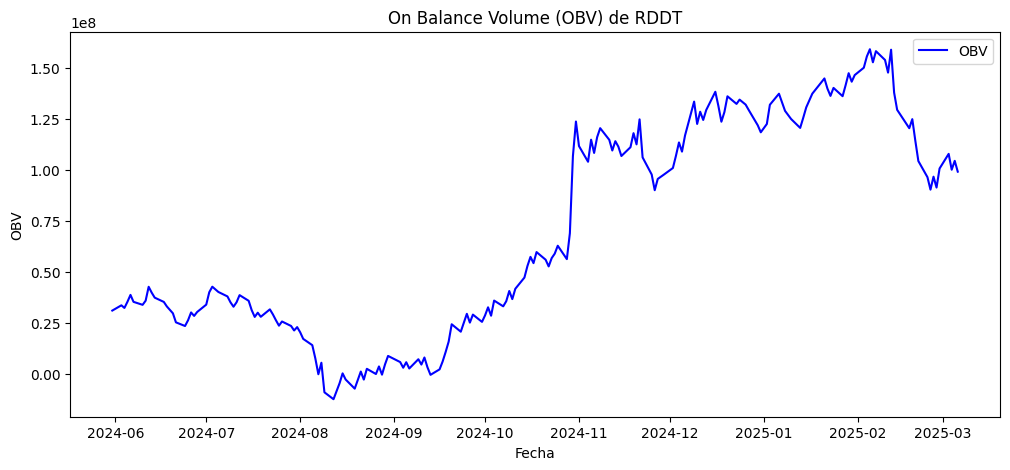

In [ ]:
## 📌 Visualización: Gráfico del OBV
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['OBV'], color='blue', label="OBV")
plt.xlabel("Fecha")
plt.ylabel("OBV")
plt.title(f'On Balance Volume (OBV) de {ticker}')
plt.legend()
plt.show()


In [ ]:
# %%
## 📌 Datos Fundamentales desde Alpha Vantage y asignación de 'Valoración'
if 'Valoración' not in data.columns:
    print("⚠️ Advertencia: La columna 'Valoración' no existe en el DataFrame. Se asignará un valor por defecto.")
    data['Valoración'] = np.nan

def obtener_valuacion_alpha(ticker, api_key):
    try:
        fd = FundamentalData(key=api_key, output_format='pandas')
        data_fundamental, _ = fd.get_company_overview(symbol=ticker)
        market_cap = float(data_fundamental.loc['MarketCapitalization'].values[0])
        return market_cap
    except Exception as e:
        print(f"❌ Error obteniendo datos fundamentales de Alpha Vantage: {e}")
        return np.nan

valuation_index = obtener_valuacion_alpha(ticker, ALPHA_VANTAGE_API_KEY)

if not np.isnan(valuation_index):
    data['Valoración'] = np.full(len(data), valuation_index, dtype=np.float64)
else:
    data['Valoración'] = 2.5  # Valor por defecto


⚠️ Advertencia: La columna 'Valoración' no existe en el DataFrame. Se asignará un valor por defecto.
❌ Error obteniendo datos fundamentales de Alpha Vantage: 'MarketCapitalization'


In [ ]:
# %%
## 📌 Nueva condición de compra con OBV y otros indicadores
buy_signal = (data['RSI'] < 30) & \
             (data['%K'] < 20) & \
             (data['MACD'] < -5) & \
             (data['Valoración'] < 2.5) & \
             (data['OBV'].diff() > 0)
data['Señal_Compra'] = 0
data.loc[buy_signal, 'Señal_Compra'] = 1


KeyError: 'Valoración'

In [ ]:
# %%
## 📌 Gráfico de Velas Japonesas con Señales Institucionales usando Plotly
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=data.index, 
    open=data['Open'], 
    high=data['High'], 
    low=data['Low'], 
    close=data['Close'], 
    name='Precio'
))
fig.add_trace(go.Scatter(
    x=data.index[data['Entrada_Capital'] == 1], 
    y=data['Close'][data['Entrada_Capital'] == 1], 
    mode='markers', 
    marker=dict(size=10, color='green', symbol='triangle-up'), 
    name='Entrada de Capital'
))
fig.add_trace(go.Scatter(
    x=data.index[data['Salida_Capital'] == 1], 
    y=data['Close'][data['Salida_Capital'] == 1], 
    mode='markers', 
    marker=dict(size=10, color='blue', symbol='triangle-down'), 
    name='Salida de Capital'
))
# Agregar señales de compra
fig.add_trace(go.Scatter(
    x=data.index[data['Señal_Compra'] == 1], 
    y=data['Close'][data['Señal_Compra'] == 1], 
    mode='markers', 
    marker=dict(size=10, color='yellow', symbol='triangle-up'), 
    name='Señal de Compra'
))
fig.update_layout(
    title=f'Señales Institucionales para {ticker}',
    xaxis_title='Fecha',
    yaxis_title='Precio',
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=600,
    width=1000
)
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
## 📌 Verificar valores de 'Valoración'
print("Valores de 'Valoración':")
print(data[['Valoración']].dropna().head())


Valores de 'Valoración':
            Valoración
date                  
2022-03-15         2.5
2022-03-16         2.5
2022-03-17         2.5
2022-03-18         2.5
2022-03-21         2.5


In [ ]:
# %%
## 📌 Obtención de datos fundamentales desde Yahoo Finance
def obtener_valuacion_yahoo(ticker):
    try:
        print(f"📊 Descargando datos fundamentales para {ticker} desde Yahoo Finance...")
        stock = yf.Ticker(ticker)
        info = stock.info
        pe_ratio = info.get("trailingPE", None)
        pb_ratio = info.get("priceToBook", None)
        ev_to_ebitda = info.get("enterpriseToEbitda", None)
        valid_metrics = [m for m in [pe_ratio, pb_ratio, ev_to_ebitda] if m is not None]
        valuation_index = sum(valid_metrics) / len(valid_metrics) if valid_metrics else None
        return pe_ratio, pb_ratio, ev_to_ebitda, valuation_index
    except Exception as e:
        print(f"❌ Error obteniendo datos fundamentales: {e}")
        return None, None, None, None

pe_ratio, pb_ratio, ev_to_ebitda, valuation_index_yahoo = obtener_valuacion_yahoo(ticker)

if valuation_index_yahoo is not None:
    print(f"📊 P/E Ratio: {pe_ratio if pe_ratio else 'N/A'} | P/B Ratio: {pb_ratio if pb_ratio else 'N/A'} | EV/EBITDA: {ev_to_ebitda if ev_to_ebitda else 'N/A'}")
    print(f"📊 Índice de Valoración (Yahoo): {valuation_index_yahoo:.2f}")
    if valuation_index_yahoo > 2.5:
        print("⚠️ La empresa está MUY SOBREVALORADA 📈 (Riesgo de caída)")
    elif valuation_index_yahoo < 1:
        print("✅ La empresa está INFRAVALORADA 📉 (Oportunidad de compra)")
    else:
        print("🔍 La empresa tiene una valoración razonable.")
else:
    print("❌ No se pudo calcular el índice de valoración desde Yahoo Finance.")


📊 Descargando datos fundamentales para MSFT desde Yahoo Finance...
📊 P/E Ratio: 32.366425 | P/B Ratio: 9.850166 | EV/EBITDA: 21.209
📊 Índice de Valoración (Yahoo): 21.14
⚠️ La empresa está MUY SOBREVALORADA 📈 (Riesgo de caída)


In [ ]:
# %%
## 📌 Agregar 'Valoración' como característica y actualizar el conjunto de entrenamiento
features = ['RSI', 'MACD', 'Signal_Line', '%K', '%D', 'Volume', 'Institutional_Index', 'Valoración']
X = data[features].values
# Si es necesario, se puede normalizar X nuevamente o ajustar el pipeline.


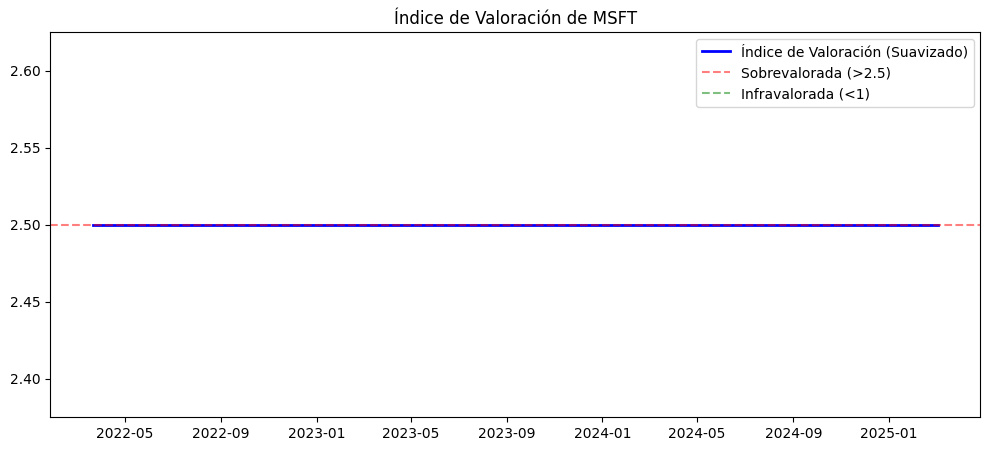

In [ ]:
## 📌 Gráfico del Índice de Valoración con suavizado
plt.figure(figsize=(12, 5))
data['Valoración_Suave'] = data['Valoración'].rolling(window=5).mean()
plt.plot(data.index, data['Valoración_Suave'], color='blue', linewidth=2, label="Índice de Valoración (Suavizado)")
min_valor = data['Valoración'].min()
max_valor = data['Valoración'].max()
margen = (max_valor - min_valor) * 0.1
plt.ylim(min_valor - margen, max_valor + margen)
plt.axhline(2.5, linestyle='--', color='red', alpha=0.5, label="Sobrevalorada (>2.5)")
plt.axhline(1, linestyle='--', color='green', alpha=0.5, label="Infravalorada (<1)")
plt.title(f'Índice de Valoración de {ticker}')
plt.legend()
plt.show()
